In [1]:
import numpy as np
from matplotlib import pyplot as plt

from loki.libloki.configs import PulsarSearchConfig
from loki.libloki.ffa import FFAPlan
from loki.libloki.prune import PruningManager
from pyloki.config import ParamLimits
from pyloki.core.taylor import generate_branching_pattern
from pyloki.detection import thresholding
from pyloki.ffa import DynamicProgramming
from pyloki.periodogram import PruningStatsPlotter, ScatteredPeriodogram
from pyloki.prune import prune_dyp_tree
from pyloki.simulation.pulse import PulseSignalConfig

tobs = 2147.483648


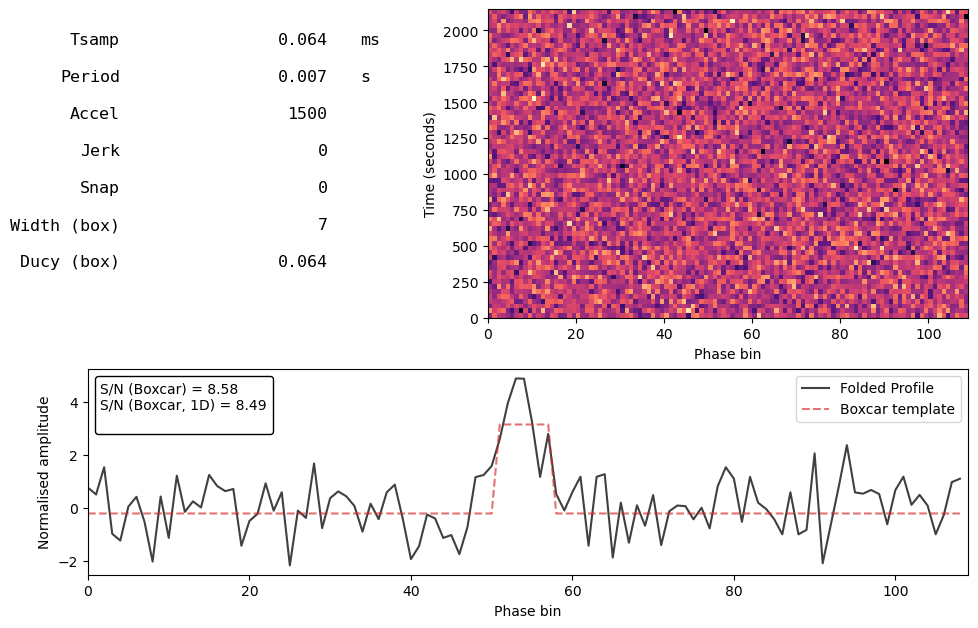

In [2]:
pulsar_period = 0.007
dt = 64e-6
accel = 1500         
nsamps = 2**25
mod_kwargs = {"acc": accel}
cfg = PulseSignalConfig(period=pulsar_period, dt=dt, nsamps=nsamps, snr=8.5, ducy=0.1, mod_kwargs=mod_kwargs)
print(f"tobs = {cfg.tobs}")
tim_data = cfg.generate(shape="gaussian")
tim_data.plot_fold(cfg.freq, cfg.fold_bins, mod_kwargs=mod_kwargs)
plt.show()

In [3]:
tol_bins = 1 
fold_bins = 64
p = ParamLimits.from_taylor((140.0, 145.0), (-2500.0, 2500.0) )
print(f"Param limits: {p.limits}")
bseg_brute = cfg.nsamps // 16384
bseg_ffa = cfg.nsamps // 128
search_cfg = PulsarSearchConfig(nsamps=cfg.nsamps, tsamp=cfg.dt, nbins=fold_bins, tol_bins=tol_bins, param_limits=p.limits,
                                bseg_brute=bseg_brute, bseg_ffa=bseg_ffa, prune_poly_order=2, nthreads=8, ducy_max=0.2, wtsp=1.1,
                                use_fft_shifts=True)
plan = FFAPlan(search_cfg)
branching_pattern = plan.generate_branching_pattern()
branching_pattern

Param limits: [(-2500.0, 2500.0), (140.0, 145.0)]


array([8.        , 3.        , 2.        , 3.        , 1.        ,
       1.        , 2.        , 3.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 3.        , 2.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 3.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       2.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 3.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 2.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

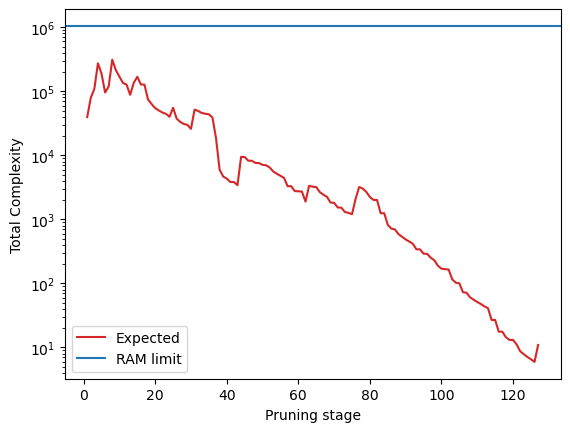

In [4]:
thresholds = np.array([2.1, 2.5, 2.6, 2.5, 2.7, 3. , 3.1, 2.9, 3.1, 3.1, 3.1, 2.9, 3.2,
       3.5, 3.6, 3.6, 3.2, 3.7, 3.6, 3.6, 3.5, 3.4, 3.3, 3.4, 3.9, 4. ,
       3.9, 3.8, 3.7, 3.8, 3.5, 3.6, 3.6, 3.5, 3.4, 3.6, 4.1, 4.5, 4.5,
       4.4, 4.4, 4. , 4.3, 4.3, 4. , 4.3, 4. , 4.2, 4. , 4.1, 4. , 4.1,
       4.2, 4.2, 4.2, 4.2, 4.4, 4. , 4.4, 4.2, 4.1, 4.5, 4.5, 4.4, 4.3,
       4.5, 4.5, 4.5, 4.6, 4.4, 4.6, 4.4, 4.6, 4.5, 4.5, 4.6, 4.4, 4.5,
       4.6, 4.7, 4.7, 4.4, 4.9, 4.5, 5. , 5. , 4.9, 5. , 5. , 5. , 5. ,
       5. , 5.1, 4.9, 5.1, 4.9, 5.1, 5.1, 5.2, 5.2, 5.1, 5. , 5.3, 5.3,
       5.2, 5.4, 5.3, 5.4, 5.4, 5.4, 5.4, 5.4, 5.4, 5.6, 5.3, 5.7, 5.3,
       5.7, 5.7, 5.3, 5.7, 5.8, 5.8, 5.8, 5.8, 5.8, 5.8])
thresh_state = thresholding.evaluate_scheme(thresholds, branching_pattern, ref_ducy=0.1, nbins=64,
                                            ntrials=1024, snr_final=8.5, ducy_max=0.2, wtsp=1.5)
x = np.arange(1, len(branching_pattern) + 1)
plt.semilogy(x, np.array(thresh_state.get_info("complexity")) * plan.ncoords[-1], label="Expected", c="tab:red")
plt.axhline(2**20, label="RAM limit", c="tab:blue")
plt.xlabel("Pruning stage")
plt.ylabel("Total Complexity")
plt.legend()
plt.show()

In [ ]:
prn_manager = PruningManager(search_cfg, thresholds, n_runs=32, max_sugg=2**20, batch_size=1024)
prn_manager.execute(tim_data.ts_e, tim_data.ts_v, outdir="pruning_results/accel_test/", file_prefix="test_accel", kind="taylor")

In [ ]:
pgram = ScatteredPeriodogram.load(result_file)
print(f"True params, a: {cfg.mod_kwargs["acc"]:.3f}, f: {cfg.freq:.10f}")
print(pgram.get_summary_cands(10, run_id=None))

In [ ]:
pgram.plot_scores(kind="scatter", run_id=None)
plt.show()

In [ ]:
pgram.plot_scores(kind="hist", run_id=None)
plt.show()

In [ ]:
pgram.plot_correlation("accel", "freq", true_values={"accel": cfg.mod_kwargs["acc"], "freq": cfg.freq}, run_id=None)
plt.show()

In [ ]:
pstats = PruningStatsPlotter.load(result_file)
fig = pstats.plot_level_stats(run_id=None)
x = np.arange(1, len(branching_pattern) + 1)
ax_list = fig.axes
ax_list[0].plot(x, np.array(thresh_state.get_info("complexity")) * dyp.nparam_vol, label="Expected", c="tab:red")
plt.show()